# Figure 7C and Figure 7E

This Jupyter Notebook generates Figure 7C, Figure 7E, Figure S6A, Figure S6B

- **Figure 7C**: Includes two parts:
  - Time series plots of simulated firing rates for Pyr and SST neurons across stationary and running states, 25%/50%/100% contrast levels, and control/DART groups.
  - Steady-state firing rates compared with empirical data for both neuron types and states.
- **Note**: This code could also be used to generate cases when all weights vary (Figure S6A) or all weights are fixed (Figure S6B) between two states.
- **Figure 7E**: A phase diagram showing stability boundaries, colored regions (stable and unstable), and data points representing the effective weights (wEE_tilde, wES_tilde) for stationary and running states across three contrast levels (25%, 50%, 100%). Stationary data points are circles, and running data points are triangles, with increasing opacity for higher contrasts.


**Dependencies**: Python 3.6+, numpy, matplotlib  
**Author**: Yingming Pei  
**Date**: 2025-05-13  
**Outputs**: Saves figures as 'FiringRates_Contrast_Fig7C.pdf' and 'PhaseDiagram_DataPoints_Fig7E.pdf'

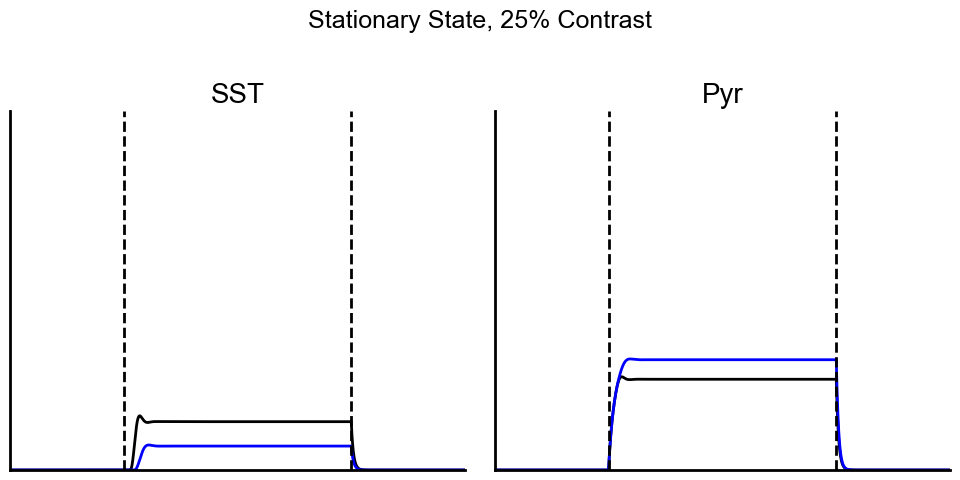

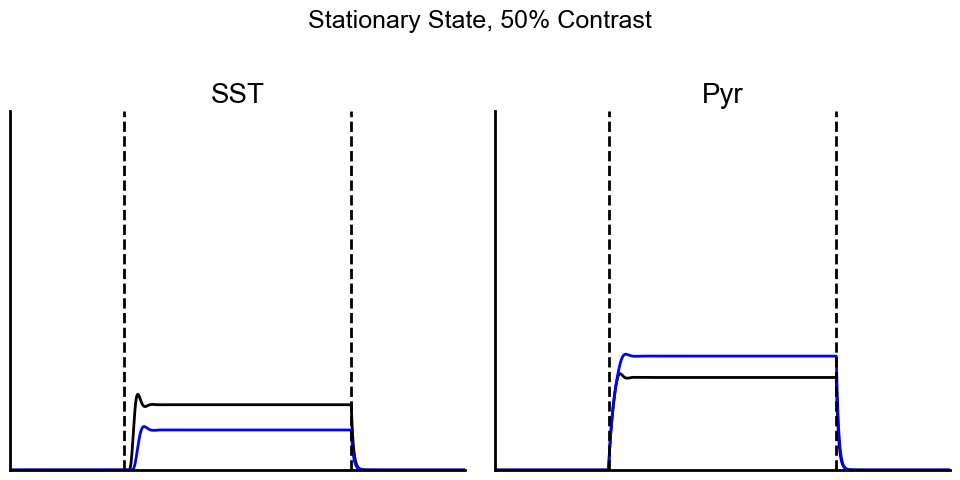

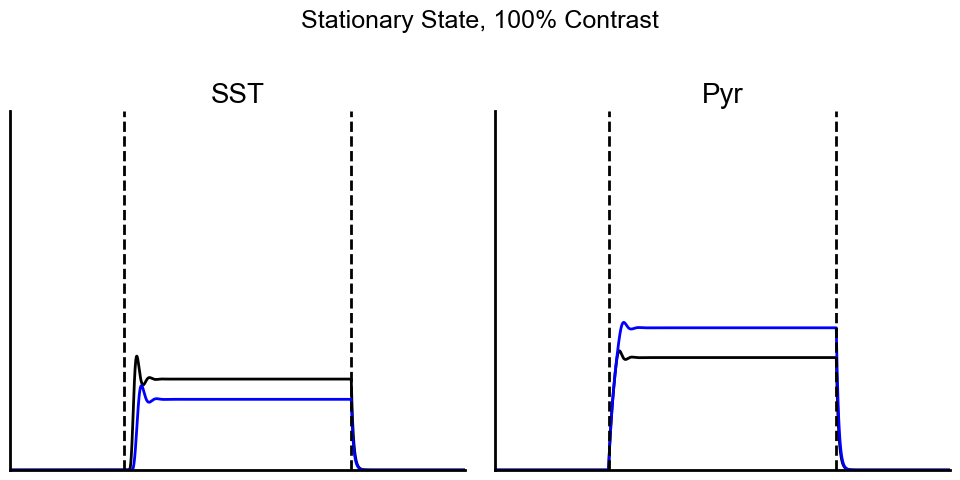

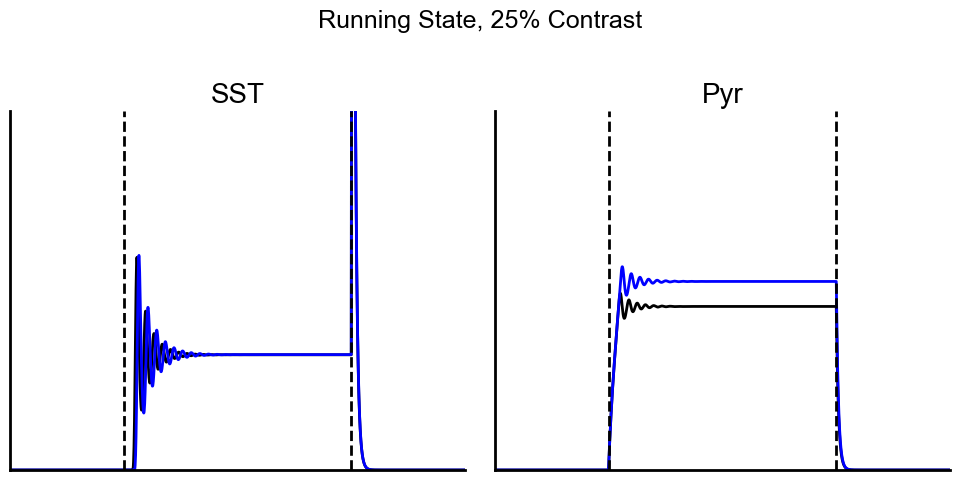

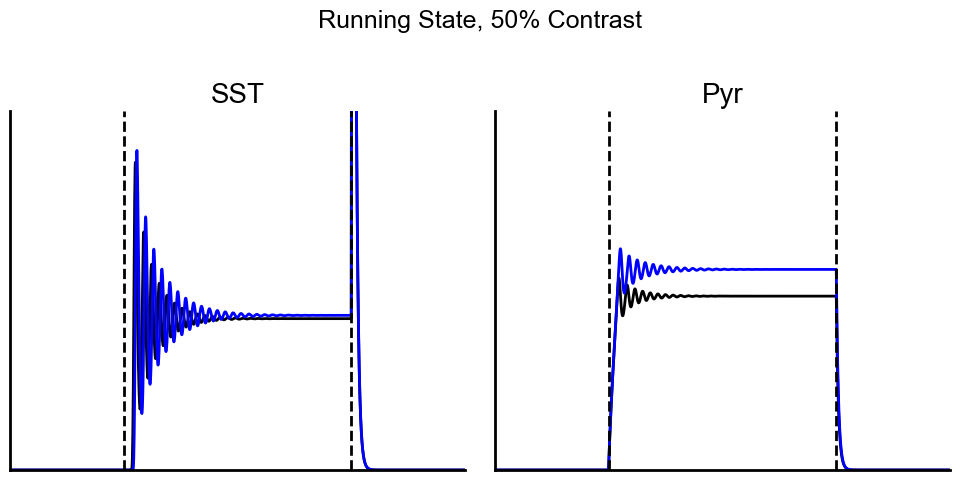

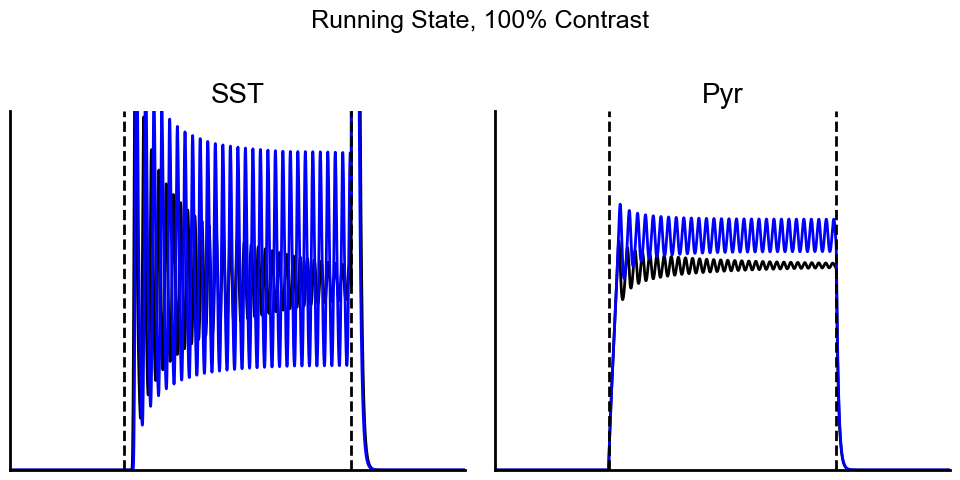

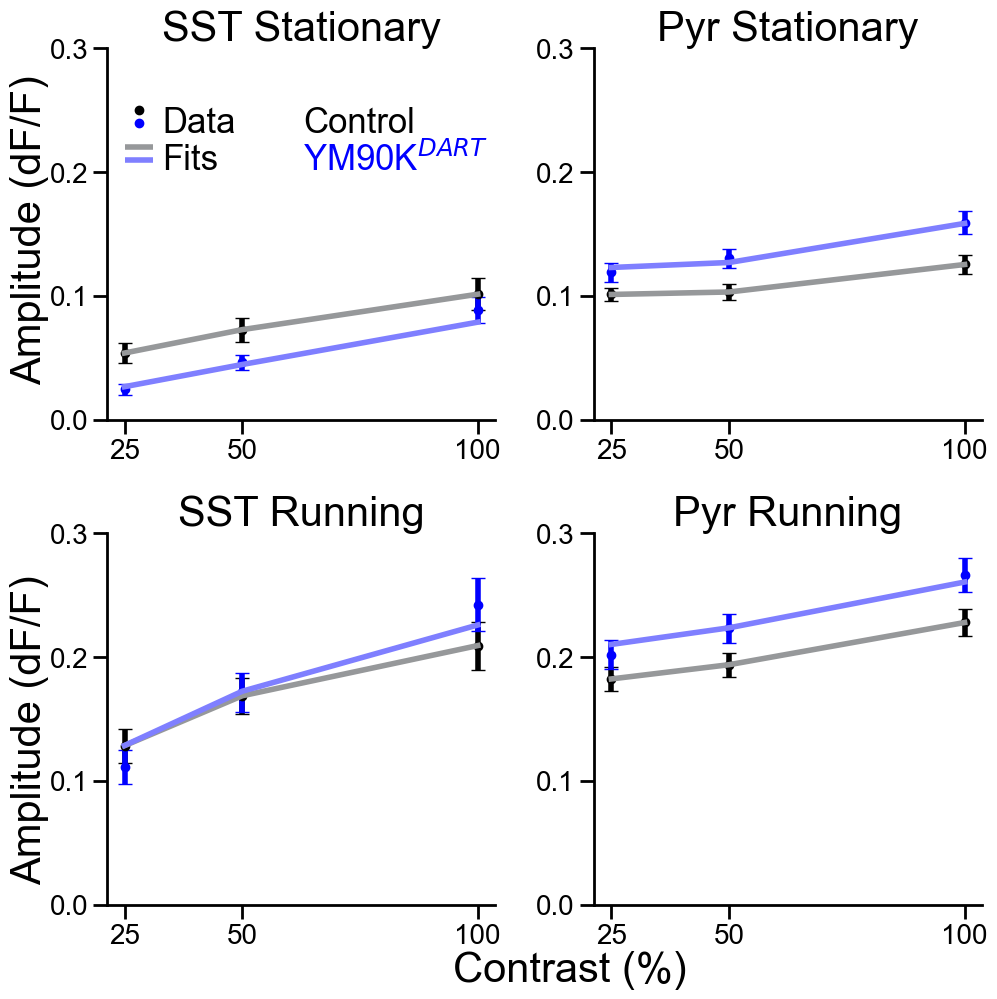

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Configure matplotlib plotting settings
def configure_plot_style():
    """Set global matplotlib parameters for consistent figure styling."""
    plt.rcParams["axes.spines.top"] = False
    plt.rcParams["axes.spines.right"] = False
    plt.rcParams["axes.linewidth"] = 2
    plt.rcParams["lines.linewidth"] = 2
    plt.rcParams["xtick.major.size"] = 10
    plt.rcParams["xtick.major.width"] = 2
    plt.rcParams["ytick.major.size"] = 10
    plt.rcParams["ytick.major.width"] = 2
    plt.rcParams["xtick.minor.size"] = 5
    plt.rcParams["xtick.minor.width"] = 2
    plt.rcParams["ytick.minor.size"] = 5
    plt.rcParams["ytick.minor.width"] = 2
    plt.rcParams["xtick.labelsize"] = 20
    plt.rcParams["ytick.labelsize"] = 20
    plt.rcParams["axes.labelsize"] = 20
    plt.rcParams["legend.fontsize"] = 20
    plt.rcParams["axes.titlesize"] = 20
    plt.rcParams["font.size"] = 20
    plt.rcParams["font.family"] = "Arial"

# Model parameters
max_time = 200  # Total time (ms)
dt = 0.1  # Time step (ms)
T = int(max_time / dt)  # Total steps
stim_start = int(0.25 * T)  # Stimulus start time
stim_end = int(0.75 * T)  # Stimulus end time
tau_e, tau_s = 1, 1  # Time constants
gain_e, gain_s = 1.289, 1.481  # Quadratic transfer function gains
re_start, rs_start = 0.0, 0.0  # Initial firing rates

# Experimental data
neuron_types = ['SST', 'Pyr']
states = ['Stationary', 'Running']
contrasts = ['25', '50', '100']
contrast_values = [0.25, 0.5, 1.0]
rEdatacontrol = np.array([[0.1012, 0.1032, 0.1254], [0.1824, 0.1939, 0.2282]])
rEdataDART = np.array([[0.1190, 0.1304, 0.1593], [0.2021, 0.2235, 0.2665]])
rSdatacontrol = np.array([[0.0539, 0.0728, 0.1014], [0.1285, 0.1688, 0.2091]])
rSdataDART = np.array([[0.0246, 0.0463, 0.0883], [0.1116, 0.1717, 0.2423]])

# Connectivity
# 11 parameters from fitting the model to the data
# 5 weights for each state and 1 DART effect

# all weights vary
# params = [1.113,  0.155,   2.227, -2.933,  1.125,
#         0.957,   0.076,  0.335, -0.959, 0.725, 0.5]

# only VIP-related weights vary
params = [0.996,  0.257,  3.601, -4.189,  0.177,
          0.996,  0.257,  3.601, -4.189 * 2.384,  0.177 * 2.384, 0.5]

# all parameters are fixed
# params = [0.959 ,  0.229,   4.948, -10.  , 0.582,
#         0.959 ,  0.229,   4.948, -10.  , 0.582, 0.5]

groups = [1.0, 1 - params[10]]  # Control and DART groups
weights = {
    states[0]: {'WEE': params[0], 'WES': params[1], 'WSE': params[2], 'WSVE': params[3], 'WSS': params[4]},
    states[1]: {'WEE': params[5], 'WES': params[6], 'WSE': params[7], 'WSVE': params[8], 'WSS': params[9]}
}

# Simulate firing rates
def simulate_firing_rates():
    """Simulate firing rates for Pyr and SST neurons across conditions."""
    fr_simulation = np.zeros((len(neuron_types), len(states), len(contrasts), len(groups), T), dtype=np.float64)
    for s, state in enumerate(states):
        for c, contrast in enumerate(contrasts):
            for g, group in enumerate(groups):
                re, rs = re_start, rs_start
                for t in range(T):
                    # External inputs during stimulus
                    I_ex_temp = 0 if t < stim_start or t > stim_end else (
                        np.sqrt(rEdatacontrol[s, c] / gain_e) -
                        weights[state]['WEE'] * rEdatacontrol[s, c] +
                        weights[state]['WES'] * rSdatacontrol[s, c]
                    )
                    I_sx_temp = -1 if t < stim_start or t > stim_end else (
                        np.sqrt(rSdatacontrol[s, c] / gain_s) -
                        (weights[state]['WSE'] - weights[state]['WSVE']) * rEdatacontrol[s, c] -
                        weights[state]['WSS'] * rSdatacontrol[s, c]
                    )
                    # Compute inputs
                    z_e = weights[state]['WEE'] * re - weights[state]['WES'] * rs + I_ex_temp
                    z_s = (weights[state]['WSE'] * group - weights[state]['WSVE']) * re + \
                          weights[state]['WSS'] * rs + I_sx_temp
                    z_e = max(z_e, 0)
                    z_s = max(z_s, 0)
                    # Update firing rates
                    re += (-re + gain_e * z_e ** 2) / tau_e * dt
                    rs += (-rs + gain_s * z_s ** 2) / tau_s * dt
                    fr_simulation[:, s, c, g, t] = [rs, re]
    return fr_simulation

# Plot time series
def plot_time_series(fr_simulation):
    """Plot time series of firing rates for each condition."""
    configure_plot_style()
    for s, state in enumerate(states):
        for c, contrast in enumerate(contrasts):
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
            # SST neurons
            ax1.set_title(f'{neuron_types[0]}')
            for g, group in enumerate(groups):
                ax1.plot(np.arange(T), fr_simulation[0, s, c, g, :],
                         label='Control' if group == 1.0 else f'x={1-group:.1f}',
                         color='black' if group == 1.0 else 'blue')
            ax1.set_xlim(0, T)
            ax1.set_ylim(0, 0.4)
            ax1.set_xticks([])
            ax1.set_yticks([])
            ax1.axvline(stim_start, color='black', ls='--')
            ax1.axvline(stim_end, color='black', ls='--')
            # Pyr neurons
            ax2.set_title(f'{neuron_types[1]}')
            for g, group in enumerate(groups):
                ax2.plot(np.arange(T), fr_simulation[1, s, c, g, :],
                         label='Control' if group == 1.0 else f'x={1-group:.1f}',
                         color='black' if group == 1.0 else 'blue')
            ax2.set_xlim(0, T)
            ax2.set_ylim(0, 0.4)
            ax2.set_xticks([])
            ax2.set_yticks([])
            ax2.axvline(stim_start, color='black', ls='--')
            ax2.axvline(stim_end, color='black', ls='--')
            # Figure settings
            plt.suptitle(f'{state} State, {contrast}% Contrast', fontsize=18)
            plt.tight_layout()
            plt.show()

# Plot steady-state firing rates with empirical data
def plot_steady_state(fr_simulation):
    """Plot steady-state firing rates compared with empirical data."""
    configure_plot_style()
    fr_steady = np.mean(fr_simulation[:, :, :, :, stim_end-500:stim_end-1], axis=4)
    exp_avg = [[(0.0539, 0.0246), (0.0728, 0.0463), (0.1014, 0.0883)],
               [(0.1012, 0.1190), (0.1032, 0.1304), (0.1254, 0.1593)],
               [(0.1285, 0.1116), (0.1688, 0.1717), (0.2091, 0.2423)],
               [(0.1824, 0.2021), (0.1939, 0.2235), (0.2282, 0.2665)]]
    exp_se = [[[0.008280, 0.004273], [0.009692, 0.006342], [0.012741, 0.010546]],
              [[0.005528, 0.007429], [0.006080, 0.007788], [0.007634, 0.009315]],
              [[0.013620, 0.013669], [0.014691, 0.015772], [0.019223, 0.021288]],
              [[0.009524, 0.011529], [0.009672, 0.011742], [0.011056, 0.013709]]]
    colors = ['black', 'blue']  # For experimental data (Control, DART)
    labels = ['Control', 'DART']
    fig = plt.figure(figsize=(10, 10))
    for s, state in enumerate(states):
        for n, neuron_type in enumerate(neuron_types):
            ax = plt.subplot(2, 2, 2 * s + n + 1)
            
            for i in range(2):
                y_values = [x[i] for x in exp_avg[2 * s + n]]
                y_errors = [x[i] for x in exp_se[2 * s + n]]
                ax.errorbar(contrast_values, y_values, yerr=y_errors, 
                            label=labels[i] if s == 0 and n == 0 else None,
                            color=colors[i], capsize=5, zorder=1, fmt='o', 
                            linestyle='none', markersize=6, elinewidth=4)
            
            for g, group in enumerate(groups):
                ax.plot(contrast_values, fr_steady[n, s, :, g],
                        label='Control' if group == 1.0 else f'x={1-group:.1f}' if s == 0 and n == 0 else None,
                        color='#96989a' if group == 1.0 else '#7f7fff', zorder=2, linewidth=4)
            ax.set_title(f'{neuron_type} {state}', fontsize=30)
            ax.set_xticks(contrast_values)
            ax.set_xticklabels(contrasts)
            ax.set_ylim(0, 0.3)
            ax.set_yticks(np.arange(0, 0.4, 0.1))
            if s==0 and n==0:
                ax.plot(0.28, 0.25, 'o', color='black', markersize=6, zorder=3)
                ax.plot(0.28, 0.24, 'o', color='blue', markersize=6, zorder=3)
                ax.hlines(y=0.22, xmin=0.25, xmax=0.31, color='#96989a', linestyle='-', linewidth=4)
                ax.hlines(y=0.21, xmin=0.25, xmax=0.31, color='#7f7fff', linestyle='-', linewidth=4)
                ax.text(0.33, 0.24, 'Data', ha='left', va='center', fontsize=25, color='black')
                ax.text(0.33, 0.21, 'Fits', ha='left', va='center', fontsize=25, color='black')
                ax.text(0.63, 0.24, 'Control', ha='left', va='center', fontsize=25, color='black')
                ax.text(0.63, 0.21, 'YM90K$^{DART}$', ha='left', va='center', fontsize=25, color='blue')

    fig.text(0.55, 0.01, 'Contrast (%)', ha='center', va='center', fontsize=30)
    fig.text(0.01, 0.25, 'Amplitude (dF/F)', ha='center', va='center', rotation='vertical', fontsize=30)
    fig.text(0.01, 0.75, 'Amplitude (dF/F)', ha='center', va='center', rotation='vertical', fontsize=30)
    
    plt.tight_layout()
    # plt.savefig('FiringRates_Contrast_Fig7C.pdf', format='pdf', dpi=400, bbox_inches='tight')
    plt.show()

# Run simulation and generate plots
fr_simulation = simulate_firing_rates()
plot_time_series(fr_simulation)
plot_steady_state(fr_simulation)

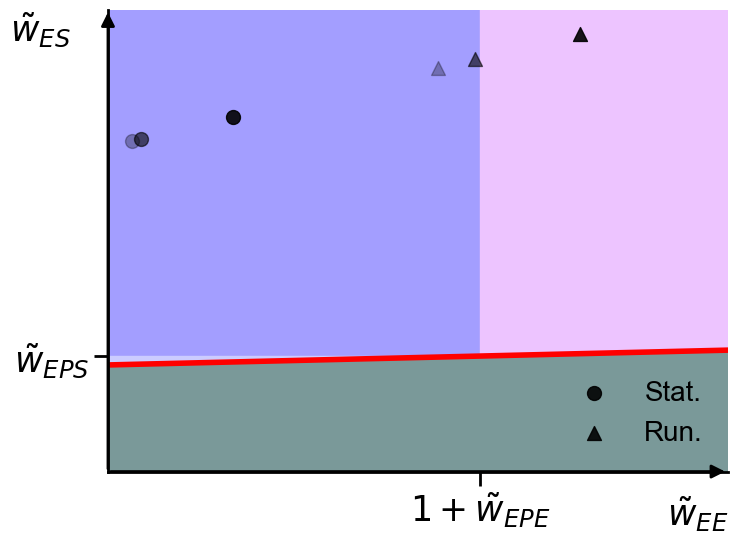

In [151]:
import numpy as np
import matplotlib.pyplot as plt

# Define model parameters and data
wee = [0.99584549, 0.99584549]  # Connection weights for stationary and running
wes = [0.25722063, 0.25722063]
rEdatacontrol = np.array([[0.1012, 0.1032, 0.1254], [0.1824, 0.1939, 0.2282]])  # Pyr firing rates
rEdataDART = np.array([[0.1190, 0.1304, 0.1593], [0.2021, 0.2235, 0.2665]])
rSdatacontrol = np.array([[0.0539, 0.0728, 0.1014], [0.1285, 0.1688, 0.2091]])  # SST firing rates
rSdataDART = np.array([[0.0246, 0.0463, 0.0883], [0.1116, 0.1717, 0.2423]])
rEseDART = np.array([[0.000055, 0.000061, 0.000087], [0.000133, 0.000138, 0.000188]])
rSseDART = np.array([[0.000018, 0.000040, 0.000111], [0.000187, 0.000249, 0.000453]])

# Calculate alphaE and alphaS
alphaE = 0.25 / rEdatacontrol[1, 1]  # Normalization factor for Pyr neurons ≈ 1.2893
alphaS = 0.25 / rSdatacontrol[1, 1]  # Normalization factor for SST neurons ≈ 1.4812

# Calculate effective weights for stationary and running states
wEE_tilde_sta = np.array([np.sqrt(rEdatacontrol[0, i] / rEdatacontrol[1, 1]) for i in range(3)]) * wee[0] - 1
wES_tilde_sta = np.array([np.sqrt(rEdatacontrol[0, i] / rEdatacontrol[1, 1]) for i in range(3)]) * wes[0]
wEE_tilde_run = np.array([np.sqrt(rEdatacontrol[1, i] / rEdatacontrol[1, 1]) for i in range(3)]) * wee[1] - 1
wES_tilde_run = np.array([np.sqrt(rEdatacontrol[1, i] / rEdatacontrol[1, 1]) for i in range(3)]) * wes[1]

# Calculate phi values for weight adjustments
phi_Es_sta = [np.sqrt(rEdatacontrol[0, i] / rEdatacontrol[0, 1]) for i in range(3)]
phi_Es_run = [np.sqrt(rEdatacontrol[1, i] / rEdatacontrol[1, 1]) for i in range(3)]
phi_Ss_sta = [np.sqrt(rSdatacontrol[0, i] / rSdatacontrol[0, 1]) for i in range(3)]
phi_Ss_run = [np.sqrt(rSdatacontrol[1, i] / rSdatacontrol[1, 1]) for i in range(3)]

# Compute adjusted weights
wEE_sta = [i + j for i, j in zip(wEE_tilde_sta, phi_Es_sta)]
wES_sta = [i + j for i, j in zip(wES_tilde_sta, phi_Es_sta)]
wEE_loco = [i + j for i, j in zip(wEE_tilde_run, phi_Es_run)]
wES_loco = [i + j for i, j in zip(wES_tilde_run, phi_Es_run)]

# Calculate stability boundary slope
wEE = wEE_sta[1]  # Stationary, 50% contrast
wES = wES_sta[1]
slope = (1 - alphaE * wEE) / (alphaE * (wES + wEE))  # Slope of the stability boundary

# Generate stability boundary line
x_values = np.linspace(-1, 1, 400)
y_values = slope * x_values

# Create phase diagram
configure_plot_style()  # Apply plot styling
plt.figure(figsize=(8, 6))

# Plot stability boundary
plt.plot(x_values, y_values, color='red', linewidth=4)

# Fill stable and unstable regions
plt.fill([0, 0, -1, -1], [0, 1, 1, 0], color=(0.639, 0.620, 1.0), zorder=1)  # Top left stable region
plt.fill([-1, -1, 0], [-slope, 0, 0], color=(0.8, 0.8, 1.0), zorder=1)  # Bottom left stable region
plt.fill([0, 0, 1, 1], [0, 1, 1, slope], color=(0.929, 0.769, 1.0), zorder=1)  # Top right stable region
plt.fill([-1, -1, 1, 1], [-1, -slope, slope, -1], color=(0.478, 0.6, 0.6), zorder=1)  # Unstable region

# Plot scatter points for stationary and running states
for i, (ee, es) in enumerate(zip(wEE_tilde_sta, wES_tilde_sta)):
    plt.scatter(ee, es, color='black', alpha=(i+1)*0.3, marker='o', zorder=2, 
                label='Stat.' if i == 2 else "", s=100)  # Stationary: circles
for i, (ee, es) in enumerate(zip(wEE_tilde_run, wES_tilde_run)):
    plt.scatter(ee, es, color='black', alpha=(i+1)*0.3, marker='^', zorder=2, 
                label='Run.' if i == 2 else "", s=100)  # Running: triangles

# Configure axes
plt.xlim(-0.3, 0.2)
plt.ylim(-0.1, 0.3)

# Set custom ticks and labels
plt.xticks([0], [r'$1+\tilde{w}_{EPE}$'], fontsize=25)
plt.yticks([0], [r'$\tilde{w}_{EPS}$'], fontsize=25)
plt.text(0.2, -0.12, r'$\tilde{w}_{EE}$', fontsize=25, ha='right', va='top')
plt.text(-0.33, 0.3, r'$\tilde{w}_{ES}$', fontsize=25, ha='right', va='top')


# Add coordinate axes with arrows
plt.annotate('', xy=(0.2, -0.1), xytext=(-0.3, -0.1), 
            arrowprops=dict(facecolor='black', linewidth=2, arrowstyle='-|>'))
plt.annotate('', xy=(-0.3, 0.3), xytext=(-0.3, -0.1), 
            arrowprops=dict(facecolor='black', linewidth=2, arrowstyle='-|>'))

# Add legend
plt.legend(frameon=False, loc='lower right', fontsize=20)

# Save and display the plot
# plt.savefig('PhaseDiagram_DataPoints_Fig7E.pdf', format='pdf', dpi=400, bbox_inches='tight')
plt.show()
